Number of geometries: 13
Spectrum length: 281

=== Training forward model (geometry -> spectrum) ===
[Forward] Epoch 1/200 Train Loss: 1.0080e+00  Val Loss: 9.5331e-01
[Forward] Epoch 20/200 Train Loss: 7.7329e-02  Val Loss: 1.5954e-01
[Forward] Epoch 40/200 Train Loss: 3.3617e-02  Val Loss: 1.8726e-01
[Forward] Epoch 60/200 Train Loss: 8.3820e-03  Val Loss: 1.2317e-01
[Forward] Epoch 80/200 Train Loss: 2.9657e-03  Val Loss: 8.3297e-02
[Forward] Epoch 100/200 Train Loss: 1.4496e-03  Val Loss: 8.6706e-02
[Forward] Epoch 120/200 Train Loss: 8.4011e-04  Val Loss: 8.5749e-02
[Forward] Epoch 140/200 Train Loss: 5.5400e-04  Val Loss: 8.2643e-02
[Forward] Epoch 160/200 Train Loss: 3.9239e-04  Val Loss: 8.0141e-02
[Forward] Epoch 180/200 Train Loss: 2.9714e-04  Val Loss: 7.7949e-02
[Forward] Epoch 200/200 Train Loss: 2.3692e-04  Val Loss: 7.6359e-02
Forward model training complete.


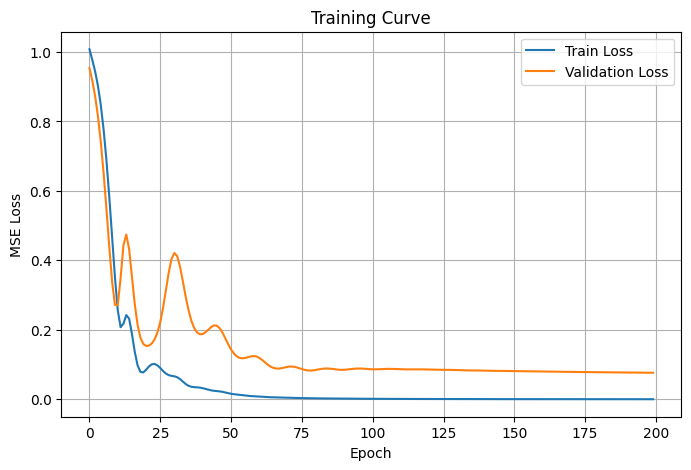


=== Starting geometry optimization for max bandwidth ===

=== Optimization restart 1/10 ===
  Step 1/1000: soft bandwidth ≈ 136.27 nm, loss=-1.3627e+02
  Step 200/1000: soft bandwidth ≈ 673.93 nm, loss=-6.7391e+02
  Step 400/1000: soft bandwidth ≈ 887.30 nm, loss=-8.8725e+02
  Step 600/1000: soft bandwidth ≈ 961.07 nm, loss=-9.6099e+02
  Step 800/1000: soft bandwidth ≈ 1009.76 nm, loss=-1.0097e+03
  Step 1000/1000: soft bandwidth ≈ 1048.33 nm, loss=-1.0482e+03
  Restart 1: hard bandwidth ≈ 1040.00 nm

=== Optimization restart 2/10 ===
  Step 1/1000: soft bandwidth ≈ 190.06 nm, loss=-1.9005e+02
  Step 200/1000: soft bandwidth ≈ 654.77 nm, loss=-6.5472e+02
  Step 400/1000: soft bandwidth ≈ 847.09 nm, loss=-8.4700e+02
  Step 600/1000: soft bandwidth ≈ 933.18 nm, loss=-9.3306e+02
  Step 800/1000: soft bandwidth ≈ 988.21 nm, loss=-9.8804e+02
  Step 1000/1000: soft bandwidth ≈ 1032.37 nm, loss=-1.0322e+03
  Restart 2: hard bandwidth ≈ 990.00 nm

=== Optimization restart 3/10 ===
  Step 1/10

In [ ]:


import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader



CSV_PATH = r"C:\Users\AL IMRAN\Desktop\Paper\Datasets\Square_Dataset.csv"  

# Wavelength grid for spectra (must cover your simulated range)
LAMBDA_MIN = 200.0
LAMBDA_MAX = 3000.0
LAMBDA_STEP = 10.0
WAVELENGTH_GRID = np.arange(LAMBDA_MIN, LAMBDA_MAX + 1e-6, LAMBDA_STEP)
N_WAVELENGTHS = len(WAVELENGTH_GRID)

BATCH_SIZE = 64
FORWARD_EPOCHS = 200          
LR_FORWARD = 1e-3


OPTIMIZATION_RESTARTS = 10    
OPTIMIZATION_STEPS = 1000
LR_GEOM = 1e-2
TARGET_THRESHOLD = 0.99      
TEMP_SOFT = 0.02              

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


# 1. LOAD & PREPROCESS DATA


df = pd.read_csv(CSV_PATH)


if "Y_axis" in df.columns:
    df = df.rename(columns={"Y_axis": "absorption"})
elif "y_axis" in df.columns:
    df = df.rename(columns={"y_axis": "absorption"})

geom_cols = ["sh", "a", "rh", "x"]


for col in geom_cols + ["wavelength", "absorption"]:
    if col not in df.columns:
        raise ValueError(f"Column '{col}' not found in CSV. Found columns: {df.columns}")


grouped = df.groupby(geom_cols)

geom_list = []
spectra_list = []

for geom_vals, group in grouped:
    group = group.sort_values("wavelength")
    lam = group["wavelength"].values
    a = group["absorption"].values


    spectrum = np.interp(WAVELENGTH_GRID, lam, a).astype(np.float32)

    geom_list.append(geom_vals)
    spectra_list.append(spectrum)

geom_array = np.array(geom_list, dtype=np.float32)          
spectra_array = np.array(spectra_list, dtype=np.float32)     

print("Number of geometries:", geom_array.shape[0])
print("Spectrum length:", spectra_array.shape[1])


# 2. NORMALIZATION


# Geometry normalization (z-score per feature)
geom_mean = geom_array.mean(axis=0)
geom_std = geom_array.std(axis=0) + 1e-8
geom_norm = (geom_array - geom_mean) / geom_std

# Spectrum normalization (global mean/std)
spec_mean = float(spectra_array.mean())
spec_std = float(spectra_array.std() + 1e-8)
spectra_norm = (spectra_array - spec_mean) / spec_std

# Train/val split
n_samples = geom_norm.shape[0]
indices = np.arange(n_samples)
np.random.shuffle(indices)

split = int(0.8 * n_samples)
train_idx = indices[:split]
val_idx = indices[split:]

X_train_geom = geom_norm[train_idx]
Y_train_spec = spectra_norm[train_idx]

X_val_geom = geom_norm[val_idx]
Y_val_spec = spectra_norm[val_idx]


# 3. DATASETS


class ForwardDataset(Dataset):
    def __init__(self, geom, spec):
        self.geom = torch.from_numpy(geom).float()
        self.spec = torch.from_numpy(spec).float()

    def __len__(self):
        return self.geom.shape[0]

    def __getitem__(self, idx):
        return self.geom[idx], self.spec[idx]

train_dataset = ForwardDataset(X_train_geom, Y_train_spec)
val_dataset = ForwardDataset(X_val_geom, Y_val_spec)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


# 4. FORWARD MODEL: geometry -> spectrum


class ForwardNet(nn.Module):
    def __init__(self, in_dim=4, out_dim=N_WAVELENGTHS):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, out_dim),
        )

    def forward(self, x):
        return self.net(x)

forward_net = ForwardNet().to(DEVICE)

criterion = nn.MSELoss()
optimizer_fwd = torch.optim.Adam(forward_net.parameters(), lr=LR_FORWARD)


geom_mean_t = torch.tensor(geom_mean, dtype=torch.float32).to(DEVICE)
geom_std_t  = torch.tensor(geom_std,  dtype=torch.float32).to(DEVICE)
spec_mean_t = torch.tensor(spec_mean, dtype=torch.float32).to(DEVICE)
spec_std_t  = torch.tensor(spec_std,  dtype=torch.float32).to(DEVICE)


# 5. TRAIN FORWARD NET

train_losses = []
val_losses = []
import matplotlib.pyplot as plt

print("\n=== Training forward model (geometry -> spectrum) ===")

for epoch in range(FORWARD_EPOCHS):
    forward_net.train()
    train_loss = 0.0

    for geom_batch, spec_batch in train_loader:
        geom_batch = geom_batch.to(DEVICE)
        spec_batch = spec_batch.to(DEVICE)

        optimizer_fwd.zero_grad()
        pred_spec = forward_net(geom_batch)
        loss = criterion(pred_spec, spec_batch)
        loss.backward()
        optimizer_fwd.step()

        train_loss += loss.item() * geom_batch.size(0)

    train_loss /= len(train_dataset)

    # Validation
    forward_net.eval()
    val_loss = 0.0
    with torch.no_grad():
        for geom_batch, spec_batch in val_loader:
            geom_batch = geom_batch.to(DEVICE)
            spec_batch = spec_batch.to(DEVICE)
            pred_spec = forward_net(geom_batch)
            loss = criterion(pred_spec, spec_batch)
            val_loss += loss.item() * geom_batch.size(0)
    val_loss /= len(val_dataset)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    if (epoch + 1) % 20 == 0 or epoch == 0:
        print(f"[Forward] Epoch {epoch+1}/{FORWARD_EPOCHS} "
              f"Train Loss: {train_loss:.4e}  Val Loss: {val_loss:.4e}")

print("Forward model training complete.")




plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Curve")
plt.legend()
plt.grid(True)
plt.show()




# 6. BANDWIDTH COMPUTATION (HARD, FOR EVALUATION)


def compute_hard_bandwidth(absorption, wavelength_grid, threshold=0.99):
    """
    absorption: 1D numpy array, same length as wavelength_grid
    Returns: max contiguous bandwidth where absorption >= threshold
    """
    mask = (absorption >= threshold)

    max_band = 0.0
    current_start = None

    for i, m in enumerate(mask):
        if m and current_start is None:
            current_start = i
        elif not m and current_start is not None:
            band = wavelength_grid[i - 1] - wavelength_grid[current_start]
            if band > max_band:
                max_band = band
            current_start = None

    # handle tail segment
    if current_start is not None:
        band = wavelength_grid[-1] - wavelength_grid[current_start]
        if band > max_band:
            max_band = band

    return max_band


# 7. SOFT BANDWIDTH OBJECTIVE (DIFFERENTIABLE)


lambda_step = LAMBDA_STEP
wavelength_grid_t = torch.tensor(WAVELENGTH_GRID, dtype=torch.float32, device=DEVICE)

def soft_bandwidth_objective(absorption_real, threshold=TARGET_THRESHOLD, temp=TEMP_SOFT):
    """
    absorption_real: tensor shape (1, N_wavelengths), real absorption in [0,1]
    Returns: scalar tensor ~ "effective bandwidth" (sum of soft mask * delta_lambda)
    """
    # Soft mask = 1 if absorption >= threshold, = 0 if much lower
    mask_soft = torch.sigmoid((absorption_real - threshold) / temp)  # (1, N)
    # Sum over wavelengths
    eff_width = torch.sum(mask_soft, dim=1) * lambda_step             # (1,)
    return eff_width.mean()


# 8. GEOMETRY OPTIMIZATION (POSITIVE FEATURES ONLY)


def denorm_geom(geom_norm_np):
    """
    Denormalize geometry from normalized space back to real values.
    """
    return geom_norm_np * geom_std + geom_mean

def optimize_geometry_bandwidth(
        num_restarts=OPTIMIZATION_RESTARTS,
        num_steps=OPTIMIZATION_STEPS,
        lr=LR_GEOM,
        threshold=TARGET_THRESHOLD):
    """
    Use the forward model as a surrogate and search for geometry that
    maximizes the effective bandwidth where A(lambda) >= threshold.

    All geometry parameters are constrained to be >= 0.
    """
    forward_net.eval()

    best_bandwidth = -1.0
    best_geom_real = None
    best_spectrum_real = None

    for restart in range(num_restarts):
        print(f"\n=== Optimization restart {restart+1}/{num_restarts} ===")

        # Initialize in normalized space: N(0,1)
        geom_norm_param = torch.randn(1, 4, device=DEVICE, requires_grad=True)

        optimizer_geom = torch.optim.Adam([geom_norm_param], lr=lr)

        for step in range(num_steps):
            optimizer_geom.zero_grad()

            # Map normalized -> real
            geom_real = geom_norm_param * geom_std_t + geom_mean_t  # (1,4)

            # Enforce positive geometry
            geom_real_clamped = torch.clamp(geom_real, min=0.0)

            # Renormalize for forward model input
            geom_input_norm = (geom_real_clamped - geom_mean_t) / geom_std_t

            # Predict normalized spectrum
            spec_pred_norm = forward_net(geom_input_norm)  # (1, N)
            # Denormalize to real absorption
            spec_pred_real = spec_pred_norm * spec_std_t + spec_mean_t  # (1, N)

            # Soft bandwidth objective (to maximize)
            eff_bw = soft_bandwidth_objective(spec_pred_real, threshold=threshold)
            # Regularization to keep geometry near training region (optional)
            reg = 1e-3 * torch.sum(geom_norm_param ** 2)

            # Loss is negative bandwidth + regularization
            loss = -eff_bw + reg
            loss.backward()
            optimizer_geom.step()

            if (step + 1) % 200 == 0 or step == 0:
                print(f"  Step {step+1}/{num_steps}: "
                      f"soft bandwidth = {eff_bw.item():.2f} nm, loss={loss.item():.4e}")

        # Evaluate this restart with hard bandwidth (non-differentiable)
        with torch.no_grad():
            geom_real_final = geom_norm_param * geom_std_t + geom_mean_t
            geom_real_final = torch.clamp(geom_real_final, min=0.0)
            geom_input_norm_final = (geom_real_final - geom_mean_t) / geom_std_t

            spec_pred_norm_final = forward_net(geom_input_norm_final)
            spec_pred_real_final = spec_pred_norm_final * spec_std_t + spec_mean_t  # (1,N)

            absorption_np = spec_pred_real_final.cpu().numpy()[0]
            bw_hard = compute_hard_bandwidth(absorption_np, WAVELENGTH_GRID, threshold=threshold)

            print(f"  Restart {restart+1}: hard bandwidth = {bw_hard:.2f} nm")

            if bw_hard > best_bandwidth:
                best_bandwidth = bw_hard
                best_geom_real = geom_real_final.cpu().numpy()[0]
                best_spectrum_real = absorption_np

    return best_geom_real, best_spectrum_real, best_bandwidth


# 9. RUN OPTIMIZATION


if __name__ == "__main__":
    print("\n=== Starting geometry optimization for max bandwidth ===")
    best_geom_real, best_spectrum_real, best_bw = optimize_geometry_bandwidth()

    print("\n===== OPTIMIZATION RESULT =====")
    print(f"Maximum hard bandwidth (A >= {TARGET_THRESHOLD}) = {best_bw:.2f} nm")

    if best_geom_real is not None:
        sh_opt, a_opt, rh_opt, x_opt = best_geom_real
        print("\nOptimal geometry (clamped to >= 0):")
        print(f"  sh = {sh_opt:.6f}")
        print(f"  a  = {a_opt:.6f}")
        print(f"  rh = {rh_opt:.6f}")
        print(f"  x  = {x_opt:.6f}")

        
        out_df = pd.DataFrame({
            "wavelength_nm": WAVELENGTH_GRID,
            "predicted_absorption": best_spectrum_real
        })
        out_df.to_csv("optimized_spectrum.csv", index=False)
        print("\nPredicted optimized spectrum saved to: optimized_spectrum.csv")
    else:
        print("No geometry found (this should not normally happen).")
